# <center> Let's play a little Plague Inc. </center>

## <center> https://github.com/DmitrySerg/COVID-19 </center>

<img src="https://i.kym-cdn.com/entries/icons/facebook/000/027/576/thumb-086-plague-inc-1-1200x675.jpg" width=700>

**Dmitry Sergeev**

**Senior Data Scientist @ ŌURA Health, Head of Data Science Programme @ Otus**

**Tg: @dmitryserg**


Data description: This project will use a collection of datasets, describing the current outbreak of coronavirus disease (COVID-19). The data includes: world airport locations, connections and estimated number of flights per month between them (taken from https://www.flightconnections.com/), estimated population on country and city level (http://worldpopulationreview.com/world-cities/), as well as the current outbreak monitoring data, provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CCSE) on the number of confirmed, recovered, and death cases (https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data).

In [1]:
# conda install --name python3 -c conda-forge cartopy

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm_notebook
from joblib import Parallel, delayed


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
#                'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
# airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
#                         names = airport_col, index_col = 0)
# airport_df.to_csv("airport_df.csv")

# connections_cols = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID',
#               'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
# connections_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
#                         names = connections_cols)
# connections_df.to_csv("connections_df.csv")

In [5]:
airport_df = pd.read_csv("../data/airport_df.csv", index_col=0)
airport_df.head()

,Name,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,Tz database time zone,type,source
ID,,,,,,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [6]:
airport_df.drop(['ICAO', 'Alt', 'Timezone', 'DST', 'Tz database time zone', 'type', 'source'], axis=1, inplace=True)
airport_df = airport_df[~airport_df.IATA.isin([r"\N"])]
airport_df.shape

(6072, 6)

In [7]:
connections_df = pd.read_csv("../data/connections_df.csv", index_col=0)
connections_df.head()

,Airline,Airline ID,Source Airport,Source Airport ID,Dest Airport,Dest Airport ID,Codeshare,Stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [8]:
connections_df.shape

(67663, 9)

In [9]:
routes = pd.read_csv("../data/routes.csv", index_col=0)
print(routes.shape)
routes.head()

(28330, 3)


,course_code,destination_code,destination_flights
0,AAA,PPT,6
1,AAA,MKP,0
2,AAA,RRR,0
3,AAA,FAC,0
4,AAK,TRW,12


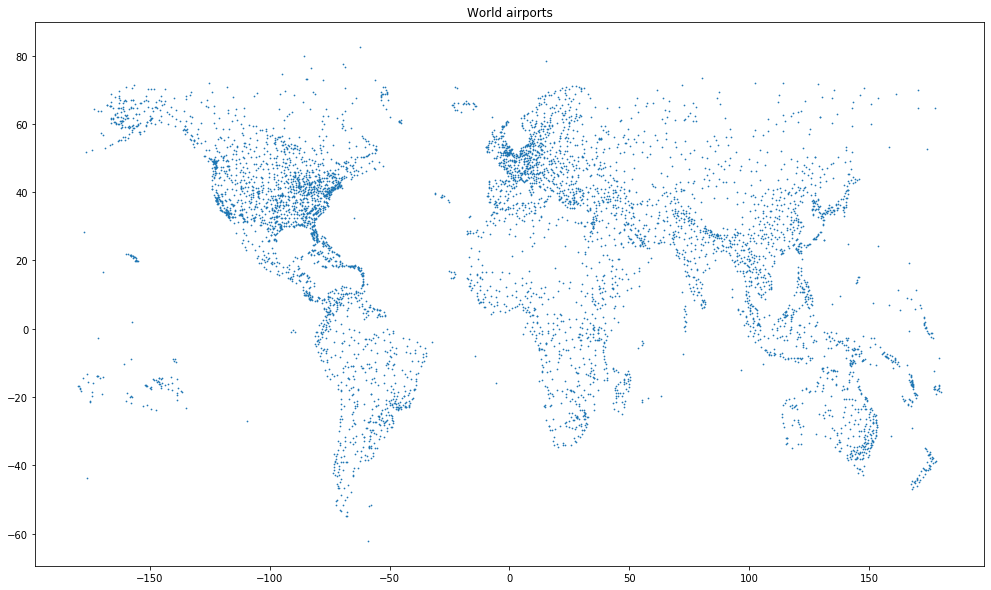

In [10]:
plt.figure(figsize=(17, 10))
plt.title("World airports")
plt.scatter(airport_df.Long, airport_df.Lat, s=0.5)
plt.show()

In [11]:
connections = pd.merge(
    connections_df, 
    routes, 
    how='left', 
    left_on=['Source Airport', 'Dest Airport'], 
    right_on=['course_code', 'destination_code']
)

connections.drop(
    ['course_code', 'destination_code', 'Codeshare', 'Stops', 'equipment'],
    axis=1, inplace=True
)

connections.columns = connections.columns.str.lower().str.split().str.join("_")

## Idea - fill missing number of flights with minimal number of flights from that source

In [12]:
MINIMAL_FLIGHTS_ESTIMATE = 0.1

In [13]:
minimal_flights = connections[
    (connections.destination_flights!=0)&(~connections.destination_flights.isnull())
].groupby(['source_airport']).destination_flights.min()

minimal_flights = np.ceil(minimal_flights*MINIMAL_FLIGHTS_ESTIMATE)

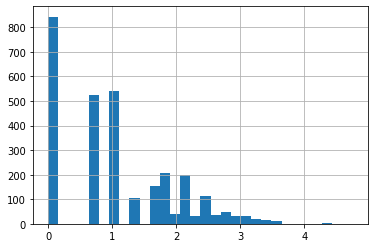

In [14]:
minimal_flights.apply(np.log).hist(bins=30);

In [15]:
connections.destination_flights[
    (connections.destination_flights.isnull())|(connections.destination_flights==0)
] = connections[
    (connections.destination_flights.isnull())|(connections.destination_flights==0)
]['source_airport'].map(minimal_flights)

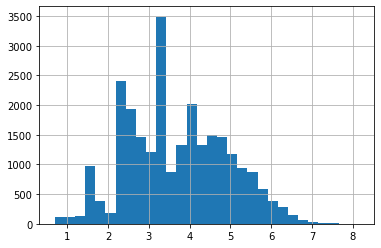

In [16]:
(routes.destination_flights[routes.destination_flights!=0]+1).apply(np.log).hist(bins=30);

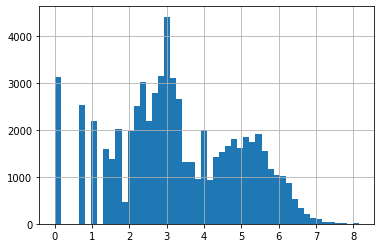

In [17]:
(connections.destination_flights).apply(np.log).hist(bins=50);

In [18]:
connections.head()

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,destination_flights
0,2B,410,AER,2965,KZN,2990,16.0
1,2B,410,ASF,2966,KZN,2990,12.0
2,2B,410,ASF,2966,MRV,2962,8.0
3,2B,410,CEK,2968,KZN,2990,1.0
4,2B,410,CEK,2968,OVB,4078,30.0


In [19]:
connections = pd.merge(
    connections, airport_df[['IATA', 'Lat', 'Long']], left_on='source_airport', right_on='IATA')

connections = pd.merge(
    connections, airport_df[['IATA', 'Lat', 'Long']], left_on='dest_airport', right_on='IATA')

connections.drop(['IATA_x', 'IATA_y'], axis=1, inplace=True)

connections.rename(columns={
    'Lat_x':'lat_source', 
    'Long_x':'long_source',
    'Lat_y':'lat_dest',
    'Long_y':'long_dest'
}, inplace=True)

In [20]:
connections.head()

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,destination_flights,lat_source,long_source,lat_dest,long_dest
0,2B,410,AER,2965,KZN,2990,16.0,43.449902,39.956600,55.606201,49.278702
1,2B,410,ASF,2966,KZN,2990,12.0,46.283298,48.006302,55.606201,49.278702
2,2B,410,CEK,2968,KZN,2990,1.0,55.305801,61.503300,55.606201,49.278702
3,2B,410,DME,4029,KZN,2990,141.0,55.408798,37.906300,55.606201,49.278702
4,S7,4329,DME,4029,KZN,2990,141.0,55.408798,37.906300,55.606201,49.278702


In [21]:
connections.fillna(connections.destination_flights.median(), inplace=True)

In [22]:
# graph = nx.from_pandas_edgelist(connections, source = 'source_airport', target = 'dest_airport',
#                        edge_attr = 'destination_flights', create_using = nx.DiGraph())

# xycoords = {}

# for node in tqdm_notebook(list(graph.nodes), leave=False):
#     xycoords[str(node)] = (
#         airport_df.Long[airport_df.IATA ==node].values[0], 
#         airport_df.Lat[airport_df.IATA == node].values[0]
#     )
    
# plt.figure(figsize=(20, 10))
# nx.draw_networkx_nodes(graph,
#                      pos=xycoords,
#                      with_labels=False,
#                      node_color='k',
#                      node_size=5,
#                      alpha=0.2);

In [23]:
population_country = pd.read_csv("../data/country_population.csv", index_col=0)
population_country.pop2019 = population_country.pop2019 * 1000
print(population_country.shape)
population_country.head()

(232, 6)


,name,pop2019,pop2018,GrowthRate,area,Density
Rank,,,,,,
1,China,1.433784e+09,NaN,1.0039,9706961.0,147.7068
2,India,1.366418e+09,NaN,1.0099,3287590.0,415.6290
3,United States,3.290649e+08,NaN,1.0059,9372610.0,35.1092
4,Indonesia,2.706256e+08,NaN,1.0107,1904569.0,142.0928
5,Pakistan,2.165653e+08,NaN,1.0200,881912.0,245.5634


In [24]:
population_city = pd.read_csv("../data/city_population.csv", index_col=0)
print(population_city.shape)
population_city.head()

(1723, 5)


,Rank,Name,2020 Population,2019 Population,Change
0,1,Tokyo,37393129,37435191,-0.11%
1,2,Delhi,30290936,29399141,3.03%
2,3,Shanghai,27058479,26317104,2.82%
3,4,Sao Paulo,22043028,21846507,0.90%
4,5,Mexico City,21782378,21671908,0.51%


## Adding city and country population

In [25]:
airport_df = pd.merge(
    airport_df, 
    population_city.rename(
        columns={"Name":"City", "2020 Population":"city_population"}
    )[['City', 'city_population']], 
    how='left', 
    left_on='City', 
    right_on='City'
)

airport_df = pd.merge(
    airport_df, 
    population_country.rename(
        columns={"name":"Country", "pop2019":"country_population", 'Density':'country_density'}
    )[['Country', 'country_population', 'country_density']], 
    how='left', 
    left_on='Country', 
    right_on='Country'
)

In [27]:
airport_df.head()

,Name,City,Country,IATA,Lat,Long,city_population,country_population,country_density
0,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.081690,145.391998,NaN,8776109.0,18.9614
1,Madang Airport,Madang,Papua New Guinea,MAG,-5.207080,145.789001,NaN,8776109.0,18.9614
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.826790,144.296005,NaN,8776109.0,18.9614
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,-6.569803,146.725977,NaN,8776109.0,18.9614
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380,147.220001,382516.0,8776109.0,18.9614


In [27]:
connections.head()

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,destination_flights,lat_source,long_source,lat_dest,long_dest
0,2B,410,AER,2965,KZN,2990,16.0,43.449902,39.956600,55.606201,49.278702
1,2B,410,ASF,2966,KZN,2990,12.0,46.283298,48.006302,55.606201,49.278702
2,2B,410,CEK,2968,KZN,2990,1.0,55.305801,61.503300,55.606201,49.278702
3,2B,410,DME,4029,KZN,2990,141.0,55.408798,37.906300,55.606201,49.278702
4,S7,4329,DME,4029,KZN,2990,141.0,55.408798,37.906300,55.606201,49.278702


Visualization idea - country population vs country density in plotly

## City population should be proportional to the number of flights from it

In [28]:
airport_df = airport_df[~airport_df.country_population.isnull()]

In [29]:
flights_number = connections.groupby(['source_airport'], as_index=False)[['destination_flights']].sum()
flights_number.head()

,source_airport,destination_flights
0,AAE,198.0
1,AAL,1092.0
2,AAN,16.0
3,AAQ,187.0
4,AAR,224.0


In [30]:
airport_df = pd.merge(airport_df, flights_number, how='left', left_on='IATA', right_on='source_airport')
#airport_df.drop(['source_airport', 'destination_flights'], axis=1, inplace=True)

In [31]:
airport_df = airport_df[~airport_df.source_airport.isnull()]

In [32]:
country_level_flights = np.ceil(
    airport_df[
        airport_df.destination_flights!=0
    ].groupby("Country")['destination_flights'].min() * MINIMAL_FLIGHTS_ESTIMATE
)

In [33]:
airport_df.destination_flights[
    airport_df.destination_flights==0
] = airport_df[
    airport_df.destination_flights==0
]['Country'].map(country_level_flights)

In [34]:
airport_df.isnull().sum()/airport_df.shape[0]

Name                   0.000000
City                   0.000313
Country                0.000000
IATA                   0.000000
Lat                    0.000000
Long                   0.000000
city_population        0.737089
country_population     0.000000
country_density        0.000000
source_airport         0.000000
destination_flights    0.000000
dtype: float64

In [35]:
airport_df[['destination_flights', 'city_population', 'country_population', 'country_density']].corr()

,destination_flights,city_population,country_population,country_density
destination_flights,1.000000,0.511136,0.161578,0.114862
city_population,0.511136,1.000000,0.131050,0.110071
country_population,0.161578,0.131050,1.000000,0.047729
country_density,0.114862,0.110071,0.047729,1.000000


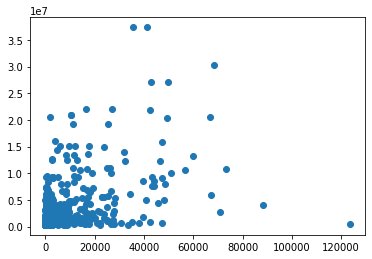

In [36]:
plt.scatter(airport_df.destination_flights, airport_df.city_population)

In [37]:
current_country = airport_df[airport_df.Country=='Russia']

In [38]:
current_country[['city_population', 'destination_flights']][~current_country.city_population.isnull()].sum()

city_population        67901103.0
destination_flights       49674.0
dtype: float64

In [39]:
flights_coefs = airport_df[
    ~airport_df.city_population.isnull()
].groupby("Country")[['city_population', 'destination_flights']].sum()
flights_coefs['coef'] = flights_coefs['city_population']/flights_coefs['destination_flights']

In [40]:
airport_df = airport_df[~airport_df.destination_flights.isnull()]

In [41]:
airport_df['flights_coefficient'] = airport_df.Country.map(flights_coefs.coef)
airport_df['flights_coefficient'].fillna(airport_df['flights_coefficient'].median(), inplace=True)

In [42]:
city_estimates = np.ceil(airport_df.flights_coefficient[airport_df.city_population.isnull()] *\
                 airport_df.destination_flights[airport_df.city_population.isnull()])

airport_df.city_population[airport_df.city_population.isnull()] = city_estimates

In [43]:
connections = connections[connections.source_airport.isin(airport_df.IATA)]
connections = connections[connections.dest_airport.isin(airport_df.IATA)]

From monthly estimates to daily

In [44]:
connections.destination_flights = connections.destination_flights/30

In [45]:
connections

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,destination_flights,lat_source,long_source,lat_dest,long_dest
0,2B,410,AER,2965,KZN,2990,0.533333,43.449902,39.956600,55.606201,49.278702
1,2B,410,ASF,2966,KZN,2990,0.400000,46.283298,48.006302,55.606201,49.278702
2,2B,410,CEK,2968,KZN,2990,0.033333,55.305801,61.503300,55.606201,49.278702
3,2B,410,DME,4029,KZN,2990,4.700000,55.408798,37.906300,55.606201,49.278702
4,S7,4329,DME,4029,KZN,2990,4.700000,55.408798,37.906300,55.606201,49.278702
...,...,...,...,...,...,...,...,...,...,...,...
66929,YN,\N,ZKE,5543,YFA,5490,1.766667,52.282501,-81.677803,52.201401,-81.696899
66930,YN,\N,YPO,5522,YAT,5482,0.266667,54.988098,-85.443298,52.927502,-82.431900
66931,YN,\N,ZKE,5543,YAT,5482,2.033333,52.282501,-81.677803,52.927502,-82.431900
66932,ZL,4178,JCK,6276,RCM,9904,0.400000,-20.668301,141.723007,-20.701900,143.115005


In [46]:
connections.columns

Index(['airline', 'airline_id', 'source_airport', 'source_airport_id',
       'dest_airport', 'dest_airport_id', 'destination_flights', 'lat_source',
       'long_source', 'lat_dest', 'long_dest'],
      dtype='object')

In [48]:
def create_graph(connections):

    G = nx.Graph() 
    allairports = set(connections.source_airport_id).union(set(connections.dest_airport_id))
    G.add_nodes_from( allairports )
    for index, row in connections.iterrows():
        G.add_edge(row['source_airport_id'] ,row['dest_airport_id'], weight = row['destination_flights'])

    return G 


In [49]:
def remove_degree(G, percentage = 10, weight = None): 
    '''remove nodes of highest degree
    weight = "weight" for weighted degree or strength (sum of weights of incident nodes)
    weight =  None for unweighted degree '''
    
    N_removed = round( G.number_of_nodes() / 100 * percentage) 
    to_be_removed = sorted(list(G.degree(weight = weight)) , key = lambda x : x[1], reverse = True)[:N_removed]
    G.remove_nodes_from(to_be_removed) 
    
    return G 
    

In [50]:
def remove_edge_betweeness(G, percentage = 30, weight = None): 
    '''remove edges of highest betweeness
    weight = "weight" for weighted betweeness 
    weight = None for unweighted betweeness (equal weights over edges) '''
    
    N_removed = round( G.number_of_edges() / 100 * percentage) 
    d = dict(nx.edge_betweenness_centrality(G, k = 1500, weight=None))
    to_be_removed = list(k for k, v in sorted(d.items(), key=lambda item: item[1], reverse = True))[:N_removed]
    G.remove_edges_from(to_be_removed)
    
    return G 

In [58]:
import random

def remove_node_nodes(G, percentage = 10): 
    '''remove nodes at random'''
    
    N_removed = round( G.number_of_nodes() / 100 * percentage) 
    to_be_removed = random.sample( list(G.nodes) , N_removed )
    G.remove_nodes_from(to_be_removed) 
    
    return G 

In [77]:
def remove_edge_random(G_red, percentage = 30): 
    '''remove edges at random'''
    
    N_removed = round( G_red.number_of_edges() / 100 * percentage)
        
    to_be_removed = random.sample( list(G_red.edges) , N_removed )
        
    G_red.remove_edges_from(to_be_removed)
    
    return G_red

In [79]:
# try 
G = create_graph(connections)
# trim by removing random nodes 
print(G.number_of_edges()) 
G_reduced = remove_edge_random(G, percentage = 30) 
print(G_reduced.number_of_edges())

18638
13047


## Network infection spread

--- 


$$P(\text{plane infected}) = \frac{I}{N}$$ 


$$P(\text{new city infected}) = 1 - P(\text{all incoming places are healthy}) = $$

$$= P(\text{all planes from city A are healthy}) \cdot P(\text{all planes from city B are healthy}) \cdot ...$$

$$= 1 - [(1 - \frac{I_A}{N_A}) ^ {f_A} \cdot (1 - \frac{I_B}{N_B}) ^ {f_B} \cdot...],$$



$I$ - number of infected in the city, $N$ - total population of the city, $f$ - flights from city per day



In [50]:
def prob_infected_plane(I, N):
    """
    I - number of infected in the city
    N - total population in the city
    """
    return I/N


def prob_city_infected(infectious_sources, populations_sources, daily_flights_sources):
    """
    Calculates the probability that the city will be infected by any of the incoming planes
    
    
    Formula used:
    P(new city infected) = 1 - P(all incoming places are healthy) = \
        = P(all planes from city A are healthy) * P(all planes from city B are healthy) * ...
        = 1 - [(1 - I_A/N_A) ^ f_A * (1 - I_B/N_B) ^ f_B * ...]
        
    """
    prob_all_planes_healthy = 1
    for I, N, f in zip(infectious_sources, populations_sources, daily_flights_sources):    
        prob_all_planes_healthy *= (1-prob_infected_plane(I, N)) ** f
        
    return 1 - prob_all_planes_healthy

In [51]:
prob_city_infected([10, 20], [10000, 20000], [100, 50])

0.1393566173169637

## <center> City infection spread (SIR) </center>

In [52]:
from scipy.integrate import odeint

class SIR:
    def __init__(self, N, I0, beta, gamma, days):
        """
        N - Total population 
        I0 - Initial number of infected individuals, 
        S0 - Everyone else is susceptible to infection initially
        Contact rate, beta, and mean recovery rate, gamma, (in 1/days)
        """
        self.N = N
        self.I0 = I0
        self.beta = beta
        self.gamma = gamma
        self.S0 = N - I0 
        self.days = days

    
    @staticmethod
    def _deriv(y, t, N, beta, gamma):
        """
        The SIR model differential equations
        """
        S, I, R = y
        #print(t)
        dSdt = -beta[int(t)] * S * I / N
        dIdt = beta[int(t)] * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    
    def run(self):
        # Initial conditions vector
        y0 = self.S0, self.I0, 0
        # Integrating the SIR equations over the time grid, t
        t = list(range(0, self.days))
        # Getting results
        result = odeint(self._deriv, y0, t, args=(self.N, self.beta, self.gamma))
        S, I, R = result.T
        return S, I, R
    
    @staticmethod
    def plot_results(S, I, R):
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, axisbelow=True)
        ax.plot(S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(I/1000, 'r', alpha=0.5, lw=2, label='Infected')
        ax.plot(R/1000, 'g', alpha=0.5, lw=2, label='Recovered')
        ax.set_xlabel('Time /days')
        ax.set_ylabel('Number (1000s)')
        #ax.set_ylim(0,1.2)
        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)
        plt.show()

In [53]:
from scipy.special import logit, expit

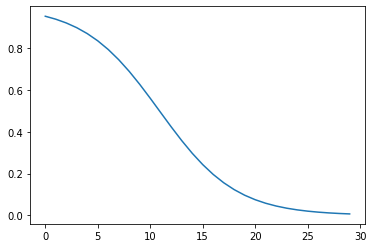

In [54]:
plt.plot(expit(np.linspace(-5, 3, num=30))[::-1])

In [55]:
max_R0 = 5
min_R0 = 1.1

beta = expit(np.linspace(-5, 3, num=60))[::-1]
beta = beta * (max_R0 - min_R0) + min_R0
beta = np.concatenate((beta, np.repeat(beta[-1], 400-len(beta))))

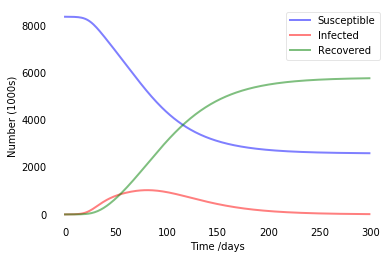

In [56]:
sir_model = SIR(8364977, I0=444, beta=beta/14, gamma=1./20, days=300)
S, I, R = sir_model.run()
sir_model.plot_results(S, I, R)

# Johns Hopkins data

In [99]:
main_link = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
CONFIRMED = pd.read_csv(main_link+'time_series_covid19_confirmed_global.csv' )
DEATHS = pd.read_csv(main_link+'time_series_covid19_deaths_global.csv')
RECOVERED = pd.read_csv(main_link+'time_series_covid19_recovered_global.csv')

In [75]:
CONFIRMED = pd.read_csv(main_link+'time_series_covid19_confirmed_global.csv' , error_bad_lines=False)
CONFIRMED

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,40,40,74,84,94,110,110,120,170,174
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,89,104,123,146,174,186,197,212,223,243
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,201,230,264,302,367,409,454,511,584,716
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,113,133,164,188,224,267,308,334,370,376
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,2,3,3,3,4,4,5,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,Turks and Caicos Islands,United Kingdom,21.694000,-71.797900,0,0,0,0,0,0,...,0,0,0,0,0,0,4,4,5,5
252,NaN,MS Zaandam,0.000000,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2,2,2
253,NaN,Botswana,-22.328500,24.684900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,4
254,NaN,Burundi,-3.373100,29.918900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [81]:
country = 'China'

confirmed_country = CONFIRMED[CONFIRMED['Country/Region']==country].sum()[4:].values
first_case = np.argwhere(confirmed_country)[0][0]
confirmed_country = confirmed_country[first_case:]

deaths_country = DEATHS[DEATHS['Country/Region']==country].sum()[4:].values[first_case:]
recovered_country = RECOVERED[RECOVERED['Country/Region']==country].sum()[4:].values[first_case:]

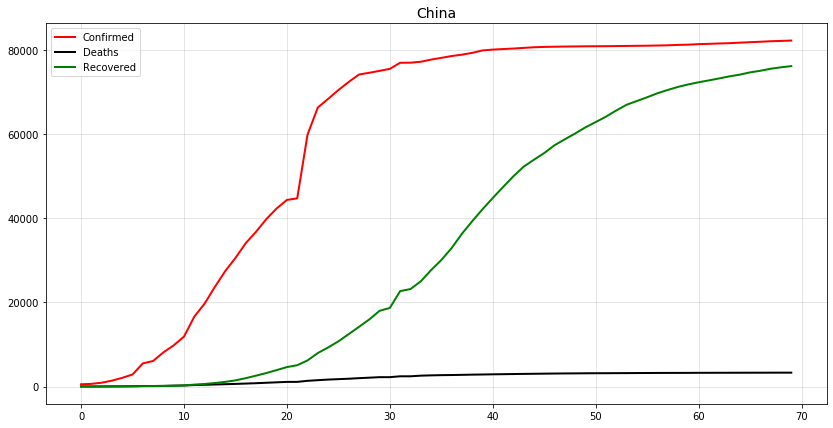

In [82]:
plt.figure(figsize=(14, 7))
plt.title(country, fontsize=14)
plt.plot(
    confirmed_country,
    linewidth=2,
    label='Confirmed',
    color='red'
)
plt.plot(
    deaths_country, 
    linewidth=2,
    label='Deaths',
    color='black'
)
plt.plot(
    recovered_country,
    linewidth=2,
    label='Recovered',
    color='green'
)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

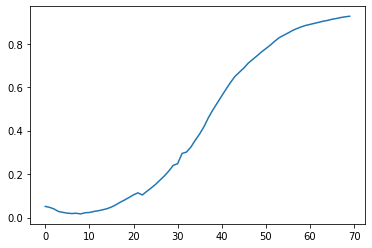

In [83]:
plt.plot(recovered_country/confirmed_country);

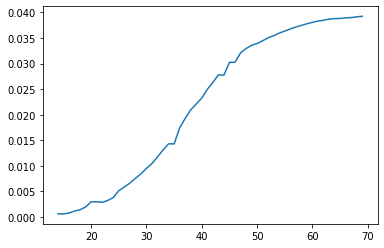

In [84]:
plt.plot(pd.Series(deaths_country).shift(14)/confirmed_country);

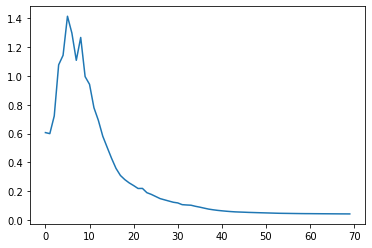

In [85]:
plt.plot(deaths_country/recovered_country);

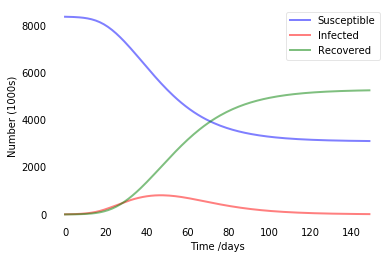

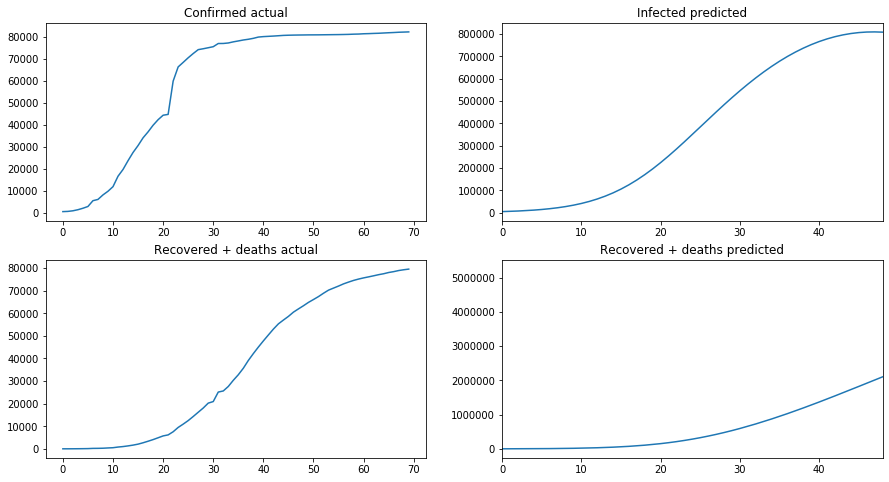

In [86]:
max_R0 = 5
min_R0 = 2.4

beta = expit(np.linspace(-5, 3, num=50))[::-1]
beta = beta * (max_R0 - min_R0) + min_R0
beta = np.concatenate((beta, np.repeat(beta[-1], 400-len(beta))))

sir_model = SIR(8364977, I0=444/0.1, beta=beta/14, gamma=0.0576*2, days=150)
S, I, R = sir_model.run()
sir_model.plot_results(S, I, R)


fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs[0, 0].plot(confirmed_country)
axs[0, 0].set_title("Confirmed actual")
axs[0, 1].plot(I)
axs[0, 1].set_title("Infected predicted")
axs[0, 1].set_xlim(0, 48)

axs[1, 0].plot(deaths_country+recovered_country)
axs[1, 0].set_title("Recovered + deaths actual")
axs[1, 1].plot(R)
axs[1, 1].set_title("Recovered + deaths predicted")
axs[1, 1].set_xlim(0, 48)
plt.show()

In [66]:
# plt.plot(pd.Series(deaths_country+recovered_country).shift(14)/confirmed_country)
# plt.show()
# plt.plot(pd.Series(R).shift(14)/S)

In [87]:
connections = connections.groupby(["source_airport", 'dest_airport'], as_index=False).agg({
    "destination_flights":np.nansum,
    "lat_source":min,
    "long_source":min,
    "lat_dest":min,
    "long_dest":min
})

In [88]:
connections_graph = nx.from_pandas_edgelist(
    connections, 
    source = 'source_airport', 
    target = 'dest_airport',
    create_using = nx.DiGraph()
)

идем по соседям, если еще не заражен - добавляем в тех, кто потенциально может быть заражен на этом шаге

In [89]:
def calculate_beta(max_R0, min_R0, simulation_days):
    beta = expit(np.linspace(-5, 3, num=60))[::-1]
    beta = beta * (max_R0 - min_R0) + min_R0
    beta = np.concatenate((beta, np.repeat(beta[-1], simulation_days)))
    return beta

SIMULATION_DAYS = 150
BETA = calculate_beta(5, 2.4, SIMULATION_DAYS)
GAMMA = 0.0576*2

In [90]:
def run_sir(city_population, first_infected_number, beta=BETA, gamma=GAMMA, days=SIMULATION_DAYS):
    sir_model = SIR(city_population, I0=first_infected_number, beta=beta/14, gamma=gamma, days=days)
    S, I, R = sir_model.run()
    return S, I, R

In [91]:
INFECTED_CITIES = {}
INFECTED_AIRPORTS = []
NEW_INFECTED = {}

AIRPORT_CODE_TO_CITY = airport_df[['City', 'IATA']].set_index("IATA").to_dict()['City']
CITY_TO_AIRPORT_CODE = airport_df[['City', 'IATA']].groupby("City")['IATA'].unique().to_dict()
CITY_TO_AIRPORT_CODE = {k:list(v) for k, v in CITY_TO_AIRPORT_CODE.items()}
CITY_POPULATION = airport_df[['City', 'city_population']].set_index("City").to_dict()['city_population']

In [92]:
def get_city_neighbours(city_name, connections_graph=connections_graph):
    city_airports = CITY_TO_AIRPORT_CODE[city_name]
    neighbours = []
    for city in city_airports:
        neighbours.extend(list(connections_graph.neighbors(city)))
    return neighbours

def get_healthy_airports(airports):
    airports = list(set(airports) - set(INFECTED_AIRPORTS))
    return airports

def get_infected_airports(airports):
    airports = list(set(airports).intersection(set(INFECTED_AIRPORTS)))
    return airports

def airports_to_cities(airports):
    return list(set([AIRPORT_CODE_TO_CITY[code] for code in airports]))


def get_number_of_flights(source, destination, connections_data=connections):
    if not isinstance(source, list):
        source = [source]
    if not isinstance(destination, list):
        destination = [destination]
        
    flights = connections_data[
        connections_data.source_airport.isin(source)&
        connections_data.dest_airport.isin(destination)
    ].destination_flights.values.sum()
    return flights


def get_infected_number(city_name, simulation_day):
    infection_day = INFECTED_CITIES[city_name]['day']
    return INFECTED_CITIES[city_name]['infected'][simulation_day-infection_day]


def calculate_infection_prob(current_susceptible_city, DAY):
    
    current_susceptible_airports = CITY_TO_AIRPORT_CODE[current_susceptible_city]
    current_infected_neighbours = get_infected_airports(get_city_neighbours(current_susceptible_city))

    flights = []
    infected_populations = []
    total_populations = []

    for infected_neighbour in current_infected_neighbours:
        infected_city_name = AIRPORT_CODE_TO_CITY[infected_neighbour]
        flights.append(get_number_of_flights(infected_neighbour, current_susceptible_airports))
        infected_populations.append(get_infected_number(infected_city_name, DAY))
        total_populations.append(CITY_POPULATION[infected_city_name])

    infection_probability = prob_city_infected(infected_populations, total_populations, flights)
    return infection_probability

def run_neighbour_simulation(current_susceptible_city, current_infection_source_city, DAY):
    
    infection_probability = calculate_infection_prob(current_susceptible_city, DAY)

    if np.random.random() < infection_probability:
        S, I, R = run_sir(
            city_population=CITY_POPULATION[current_susceptible_city],
            first_infected_number=100
        )

#         NEW_INFECTED.update({current_susceptible_city:{
#             'day':DAY, 
#             'infected':I,
#             'susceptible':S,
#             'recovered':R,
#             'from': current_infection_source_city
#         }})
        
        return {current_susceptible_city:{
            'day':DAY, 
            'infected':I,
            'susceptible':S,
            'recovered':R,
            'from': current_infection_source_city
        }}
        
        
def run_infectious_city_simulation(current_infection_source_city, DAY):
    neighbour_airports = get_city_neighbours(current_infection_source_city)
    susceptible_airports = get_healthy_airports(neighbour_airports)
    susceptible_cities = airports_to_cities(susceptible_airports)
    
    results = []
    for current_susceptible_city in tqdm_notebook(
        susceptible_cities, 
        leave=False, 
        desc='susceptible', 
        disable=not VERBOSE
    ):
        try:
            results.append(run_neighbour_simulation(current_susceptible_city, current_infection_source_city, DAY))
        except:
            continue
        
#     pool = Pool(6)
#     results = list(
#         tqdm_notebook(pool.imap(
#             run_neighbour_simulation, susceptible_cities,
#         ), desc="parallel processing", disable=not VERBOSE, leave=False, total=len(susceptible_cities)))
#     pool.close()
    results = [res for res in results if res]
    return results

In [93]:
from multiprocessing import Pool
from collections import ChainMap

In [94]:
VERBOSE = True

DAY = 0

In [95]:
S, I, R = run_sir(CITY_POPULATION['Wuhan'], 444/0.1)
INFECTED_CITIES = {'Wuhan':{'day':0, 'infected':I, 'susceptible':S, 'recovered':R, 'from':'Wuhan'}}
INFECTED_AIRPORTS = ['WUH']

In [96]:
import pickle

In [ ]:
# with open("INFECTED_CITIES", 'wb') as f:
#     pickle.dump(INFECTED_CITIES, f)

In [ ]:
for DAY in tqdm_notebook(range(0, 50), desc='Day', leave=False):

    results = Parallel(n_jobs=6, prefer="threads")(
        delayed(run_infectious_city_simulation)(
            current_infection_source_city, DAY
        ) for current_infection_source_city in tqdm_notebook(INFECTED_CITIES.keys(),
                                                             leave=False, 
                                                             desc='infection sources',
                                                             disable=not VERBOSE))
    results = sum(results, [])
    NEW_INFECTED.update(dict(ChainMap(*results)))
    
#     for current_infection_source_city in tqdm_notebook(
#         INFECTED_CITIES.keys(),
#         leave=False, 
#         desc='infection sources',
#         disable=not VERBOSE
#         ):

#         run_infectious_city_simulation(current_infection_source_city, DAY)
#         #NEW_INFECTED.update(dict(ChainMap(*results)))

    INFECTED_CITIES.update(NEW_INFECTED)
    NEW_INFECTED = {}
    INFECTED_AIRPORTS = sum([CITY_TO_AIRPORT_CODE[city] for city in INFECTED_CITIES.keys()], [])
    #print(pd.DataFrame(INFECTED_CITIES).T['from'].unique())

    with open("INFECTED_CITIES", 'wb') as f:
        pickle.dump(INFECTED_CITIES, f)

In [77]:
with open("INFECTED_CITIES", 'rb') as f:
    INFECTED_CITIES = pickle.load(f)

In [78]:
INFECTED_DF = pd.DataFrame(INFECTED_CITIES).T
INFECTED_DF.head()

,day,infected,susceptible,recovered,from
Wuhan,0,"[4440.0, 5604.499991855228, 7065.295906397263,...","[8360537.0, 8358796.534784073, 8356609.1984424...","[0.0, 575.9652240721149, 1302.5056511046628, 2...",Wuhan
Dalian,0,"[100.0, 126.25428518867183, 159.20824643879962...","[5617749.0, 5617709.772169908, 5617660.4488643...","[0.0, 12.97354490130098, 29.342889254656033, 4...",Wuhan
Chongqing,0,"[100.0, 126.25488032718492, 159.21004146299487...","[15872079.0, 15872039.771544375, 15871990.4469...","[0.0, 12.973575299230964, 29.343049936377074, ...",Wuhan
Enshi,1,"[100.0, 126.24630632928468, 159.1844619384215,...","[586567.0, 586527.7805520962, 586478.474783398...","[0.0, 12.973141574859548, 29.340754664084717, ...",Wuhan
Kunming,3,"[100.0, 126.25403964042488, 159.2075263159264,...","[4443086.0, 4443046.772427863, 4442997.4496496...","[0.0, 12.973532494532671, 29.342824032370995, ...",Dalian


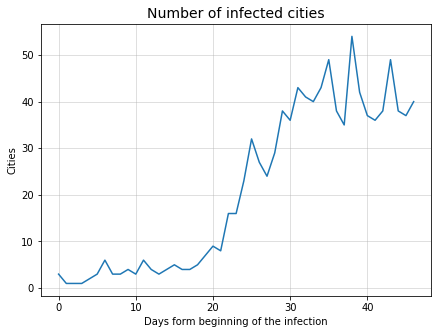

In [83]:
plt.figure(figsize=(7, 5))
plt.plot(INFECTED_DF.groupby('day')['infected'].count())
plt.title("Number of infected cities", fontsize=14)
plt.ylabel("Cities")
plt.xlabel("Days form beginning of the infection")
plt.grid(alpha=0.5)
plt.show()

In [100]:
result_cities = INFECTED_DF[['from', 'day']].reset_index()
result_cities.columns = ['destination', 'source', 'day']
result_cities = result_cities[['source', 'destination', 'day']]
result_cities.head()

,source,destination,day
0,Wuhan,Wuhan,0
1,Wuhan,Dalian,0
2,Wuhan,Chongqing,0
3,Wuhan,Enshi,1
4,Dalian,Kunming,3


In [102]:
result_cities = pd.merge(
    result_cities, airport_df[['City', 'Lat', 'Long']], left_on='source', right_on='City')

result_cities = pd.merge(
    result_cities, airport_df[['City', 'Lat', 'Long']], left_on='destination', right_on='City')

result_cities.drop(['City_x', 'City_y'], axis=1, inplace=True)
result_cities.rename(columns={
    'Lat_x':'lat_source', 
    'Long_x':'long_source',
    'Lat_y':'lat_dest',
    'Long_y':'long_dest'
}, inplace=True)

In [107]:
result_cities

,source,destination,day,lat_source,long_source,lat_dest,long_dest
0,Wuhan,Wuhan,0,30.783800,114.208000,30.783800,114.208000
1,Wuhan,Dalian,0,30.783800,114.208000,38.965698,121.539001
2,Wuhan,Chongqing,0,30.783800,114.208000,29.719200,106.641998
3,Wuhan,Enshi,1,30.783800,114.208000,30.320299,109.485001
4,Wuhan,Chengdu,4,30.783800,114.208000,30.578501,103.946999
...,...,...,...,...,...,...,...
1580,Malmoe,Visby,46,55.536305,13.376198,57.662800,18.346201
1581,Bahrain,Najaf,46,26.270800,50.633598,31.989853,44.404317
1582,Mahe,Praslin,46,-4.674340,55.521801,-4.319290,55.691399
1583,Kuching,Mukah,46,1.484700,110.347000,2.906390,112.080002


In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [108]:
graph = nx.from_pandas_edgelist(
    result_cities, 
    source = 'source', 
    target = 'destination',
    create_using = nx.DiGraph()
)

xycoords = {}

for node in tqdm_notebook(list(graph.nodes), leave=False):
    xycoords[str(node)] = (
        airport_df.Long[airport_df.City ==node].values[0], 
        airport_df.Lat[airport_df.City == node].values[0]
    )

In [116]:
from ipywidgets import interactive

def g(x, y):
    graph = nx.from_pandas_edgelist(
        result_cities[result_cities.day<=x], 
        source = 'source', 
        target = 'destination',
        create_using = nx.DiGraph()
    )
    plt.figure(figsize=(30, 15))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    ax.add_feature(cfeature.LAND, color='#3d3d3d')
    ax.add_feature(cfeature.OCEAN, color='#04031c')
    #ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.outline_patch.set_visible(False)

    if y=='Nodes':
        nx.draw_networkx_nodes(graph,
                             pos=xycoords,
                             with_labels=False,
                             node_color='r',
                             node_size=5,
                             alpha=1)
    else:
        nx.draw_networkx(graph,
                     arrows=False,
                     pos=xycoords,
                     with_labels=False,
                     node_color='r',
                     edge_color='orange',
                     style='dashed',
                     node_size=10,
                     alpha=1)

    plt.xlim(-180, 180)
    plt.ylim(-60, 80) 
    plt.show()

interactive_plot = interactive(g, x=list(range(0, 47)), y=['Nodes', 'Nodes and paths'])
interactive_plot

interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [86]:
graph = nx.from_pandas_edgelist(
    connections, 
    source = 'source_airport', 
    target = 'dest_airport',
    edge_attr = 'destination_flights', 
    create_using = nx.DiGraph()
)


xycoords = {}

for node in tqdm_notebook(list(graph.nodes), leave=False):
    xycoords[str(node)] = (
        airport_df.Long[airport_df.IATA ==node].values[0], 
        airport_df.Lat[airport_df.IATA == node].values[0]
    )

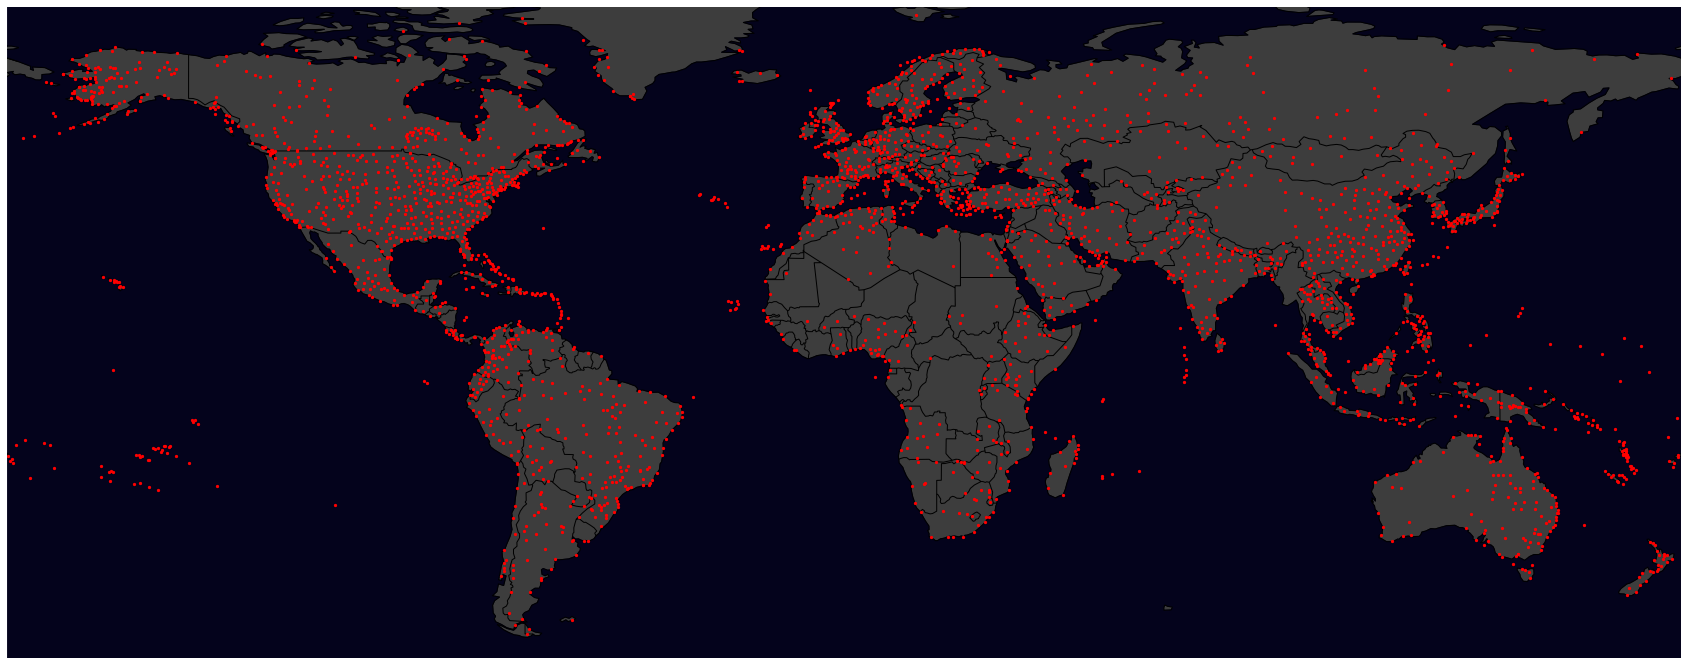

In [87]:
plt.figure(figsize=(30, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.add_feature(cfeature.LAND, color='#3d3d3d')
ax.add_feature(cfeature.OCEAN, color='#04031c')
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.outline_patch.set_visible(False)

nx.draw_networkx_nodes(graph,
                     pos=xycoords,
                     with_labels=False,
                     node_color='r',
                     node_size=5,
                     alpha=1)

plt.xlim(-180, 180)
plt.ylim(-60, 80) 
plt.show()

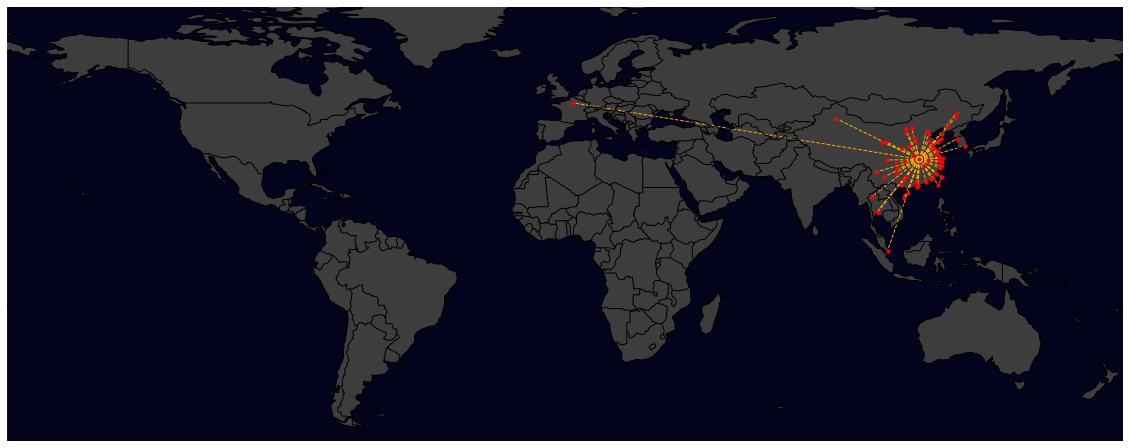

In [88]:
graph = nx.from_pandas_edgelist(
    connections[connections.source_airport=='WUH'], 
    source = 'source_airport', 
    target = 'dest_airport',
    edge_attr = 'destination_flights', 
    create_using = nx.DiGraph()
)

plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.add_feature(cfeature.LAND, color='#3d3d3d')
ax.add_feature(cfeature.OCEAN, color='#04031c')
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.outline_patch.set_visible(False)


nx.draw_networkx(graph,
                 arrows=False,
                 pos=xycoords,
                 with_labels=False,
                 node_color='r',
                 edge_color='orange',
                 style='dashed',
                 node_size=10,
                 alpha=1)

plt.xlim(-180, 180)
plt.ylim(-60, 80)
plt.show()